# Dataset Creation

This notebook goes through the steps involved in creating the dataset from the raw satellite image files from EUMETSAT.

## Step 1 : Downloading Images

The images were downloaded from [EUMETSAT](https://navigator.eumetsat.int/product/EO:EUM:DAT:0081) in the "png" file format. The images are available in tar archives of the following structure:

```
.<order_number>.tar
|- METEOSAT7-MVIRI-MTP15-NA-NA-<timestamp.timezone>-<isostring>-<order_number>.tar.gz
   |- IR108_<isostring>-<order_number>.png
   |- VIS6_<isostring>-<order_number>.png
   |_ WV73_<isostring>-<order_number>.png
```

## Step 2 : Extract and Merge the images

In [ ]:
import tarfile
import glob
import io
from PIL import Image
import matplotlib.pyplot as plt

... Found 156 images


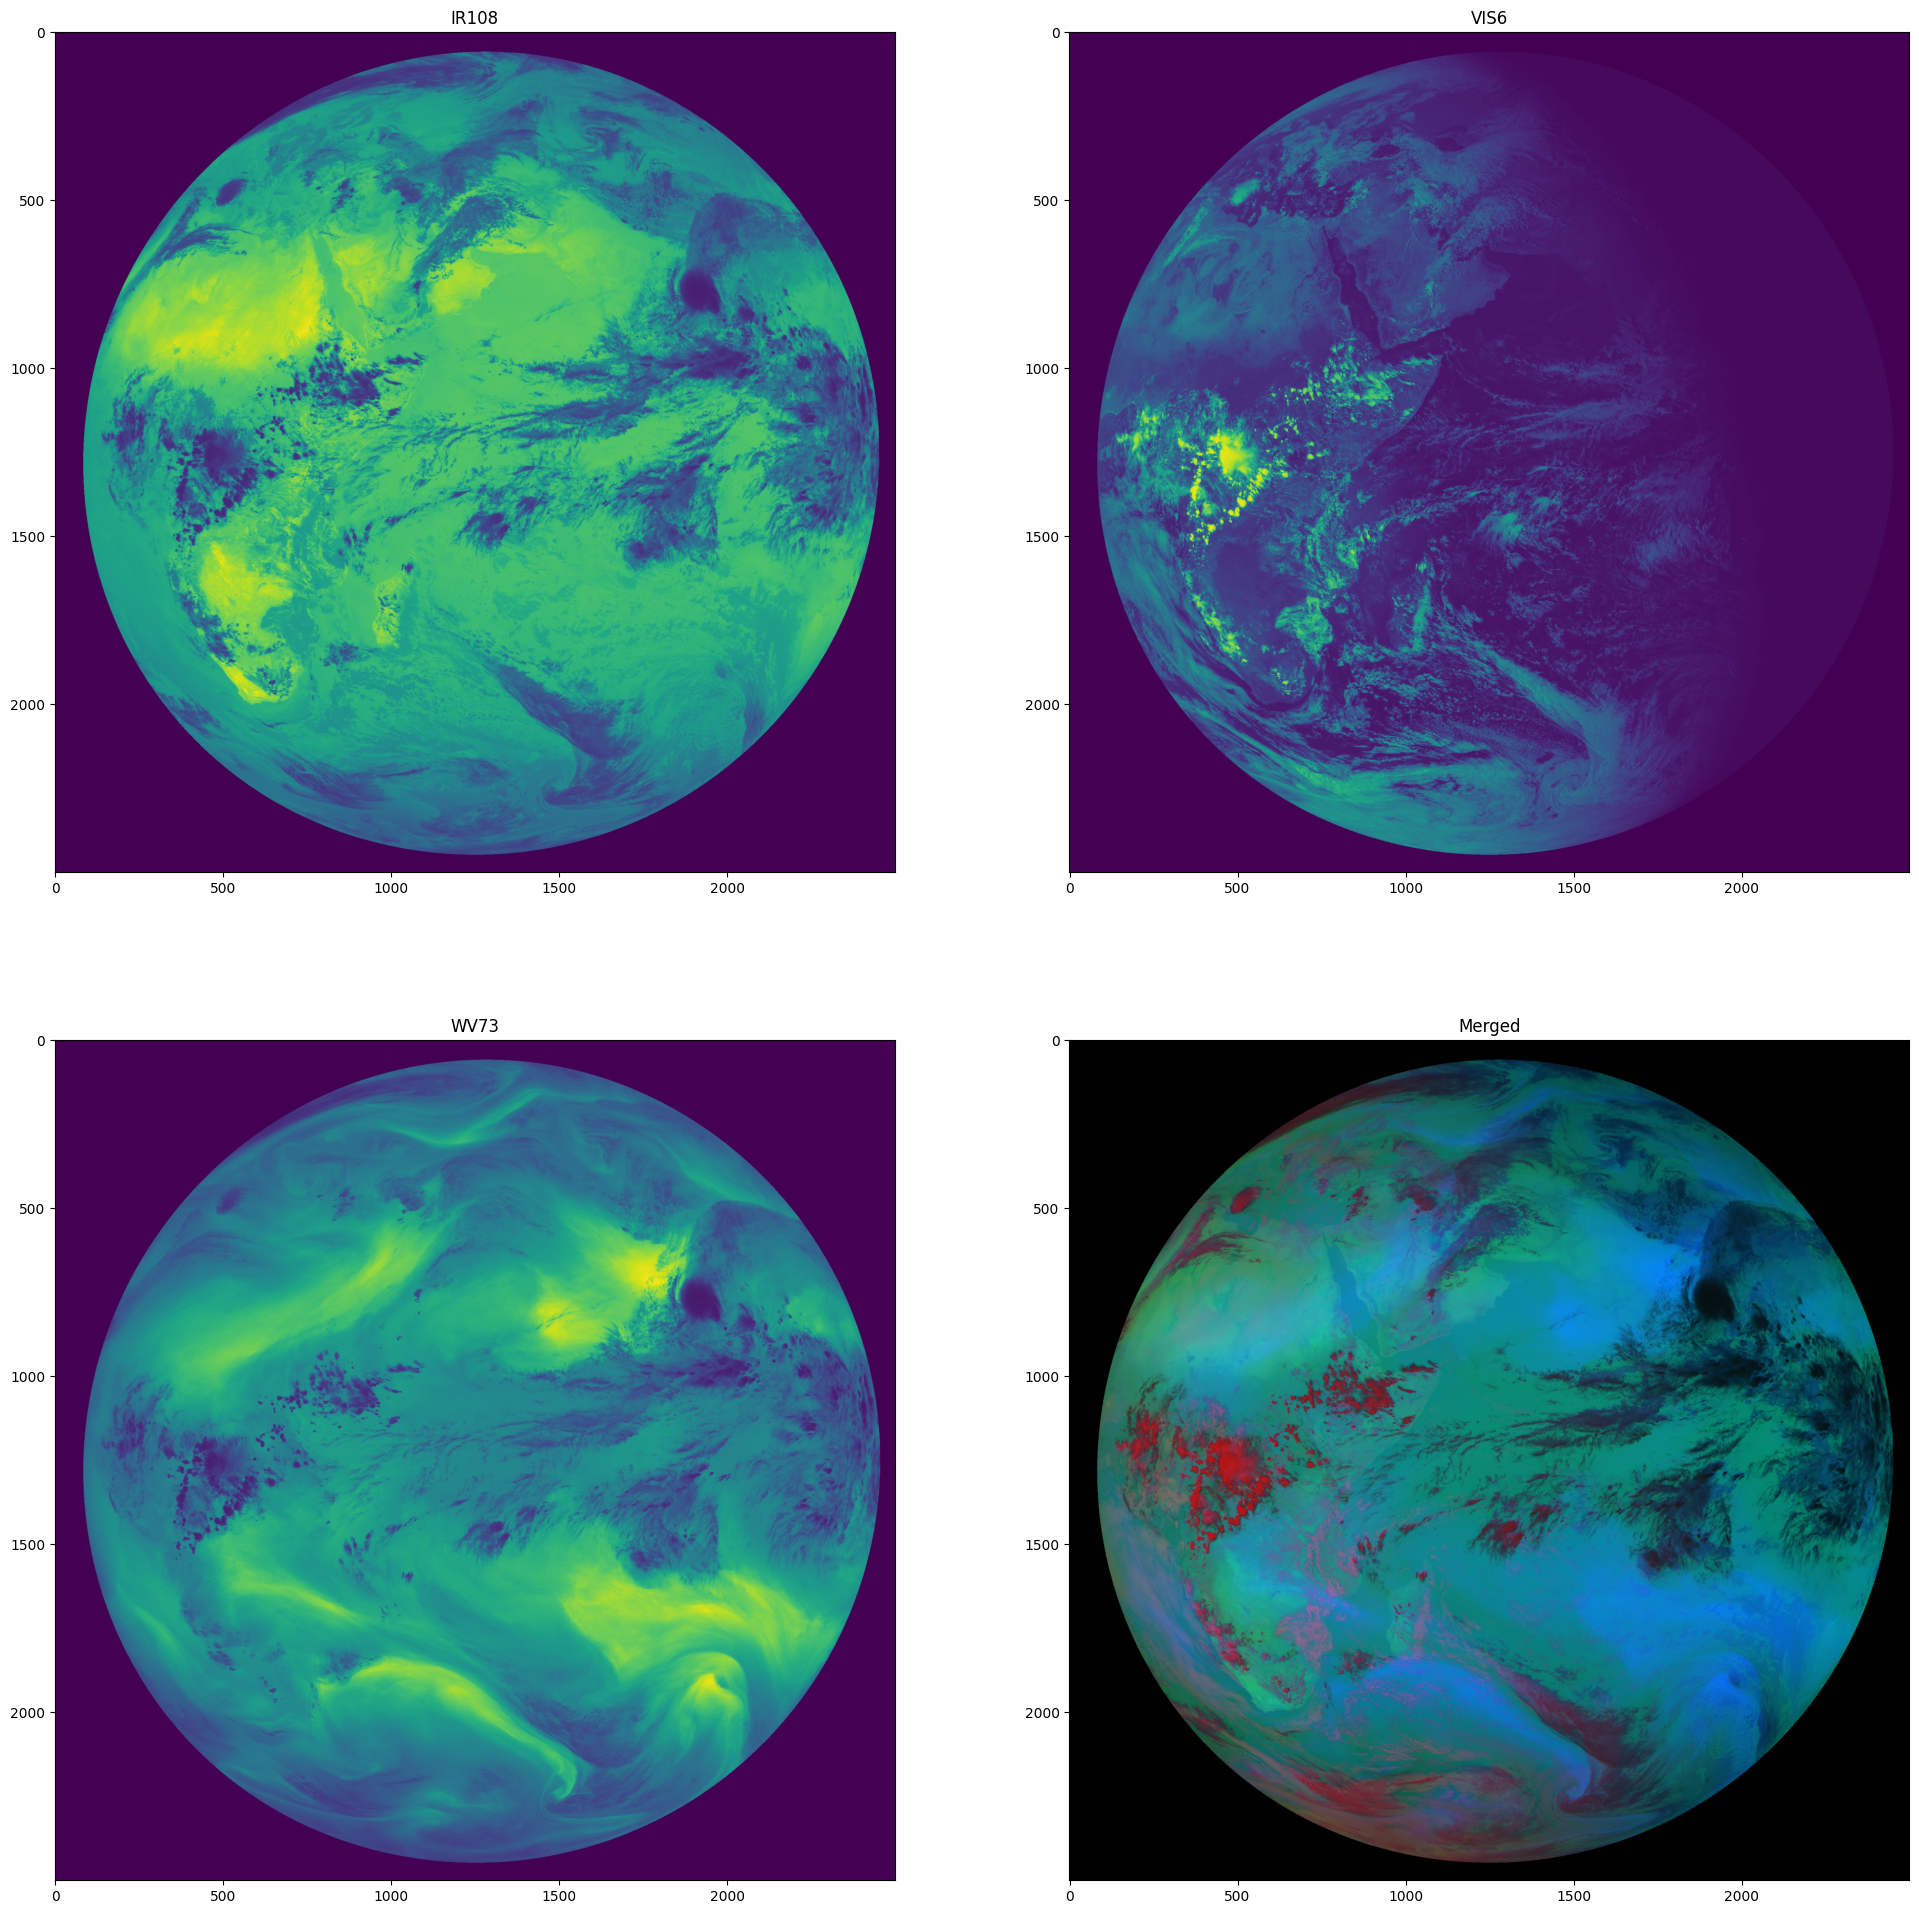

In [14]:
order_path = '..\\eumetsat_dataset\\archive.eumetsat.int\\umarf-gwt\\onlinedownload\\Naimish\\'
orders = glob.glob(order_path+'**\\*.tar', recursive=True)

tar_path = orders[10]

with tarfile.open(tar_path, 'r') as tar:
    members = tar.getmembers()
    print(f"... Found {len(members)} images")
    skip = 0
    duplicate = 0

    for member in members:
        inner_tar = tar.extractfile(member).read()
        stream = io.BytesIO(inner_tar)
        stream.seek(0)

        with tarfile.open(fileobj=stream, mode='r') as images:
            channels = images.getmembers()
            IR = None
            VIS = None
            WV = None
            timestamp = ''
            for channel in channels:
                if channel.size/1024 < 60:
                    skip += 1
                    break

                timestamp = channel.name.split('-')[-1][:-4]

                if 'IR108' in channel.name:
                    f = images.extractfile(channel).read()
                    img_stream = io.BytesIO(f)
                    IR = Image.open(img_stream).convert('L')

                if 'VIS6' in channel.name:
                    f = images.extractfile(channel).read()
                    img_stream = io.BytesIO(f)
                    VIS = Image.open(img_stream).convert('L').resize((2500,2500))

                if 'WV73' in channel.name:
                    f = images.extractfile(channel).read()
                    img_stream = io.BytesIO(f)
                    WV = Image.open(img_stream).convert('L')
            else:
                if None in [VIS, IR, WV]:
                    skip += 1
                    continue

                image = Image.merge('RGB', [VIS, IR, WV]) # VIS, IR, WV | IR, VIS, WV | WV, IR, VIS
                
                # Plot images
                imgs = {
                    "IR108": IR,
                    "VIS6": VIS,
                    "WV73": WV,
                    "Merged": image
                }

                _, axs = plt.subplots(2, 2, figsize=(24, 24))
                axs = axs.flatten()
                for (title, img), ax in zip(imgs.items(), axs):
                    ax.imshow(img)
                    ax.set_title(title, fontsize=12)

                plt.show()
                break

## Step 3 : Calculating Motion Vectors

Wind Velocity is estimated based on the Iterative Lukas-Kanade algorithm. The algorithm estimates motion between two consecutive satellite images by computing the optical flow — the apparent motion of brightness patterns. It assumes that small patches of the image undergo constant motion and solves for the displacement vector that best aligns them. In this context, ILK is applied to the infrared (IR) and water vapor (WV) channels of geostationary satellite imagery. By measuring how pixel intensities shift across time within concentric bands around a cyclone center, the algorithm estimates local wind vectors, effectively capturing the radial structure and motion of the cyclone across different atmospheric layers.

In [28]:
import cv2
import numpy as np
import pandas as pd
from skimage.registration import optical_flow_ilk
from skimage.draw import polygon2mask, polygon
import cartopy.crs as ccrs
from datetime import timedelta

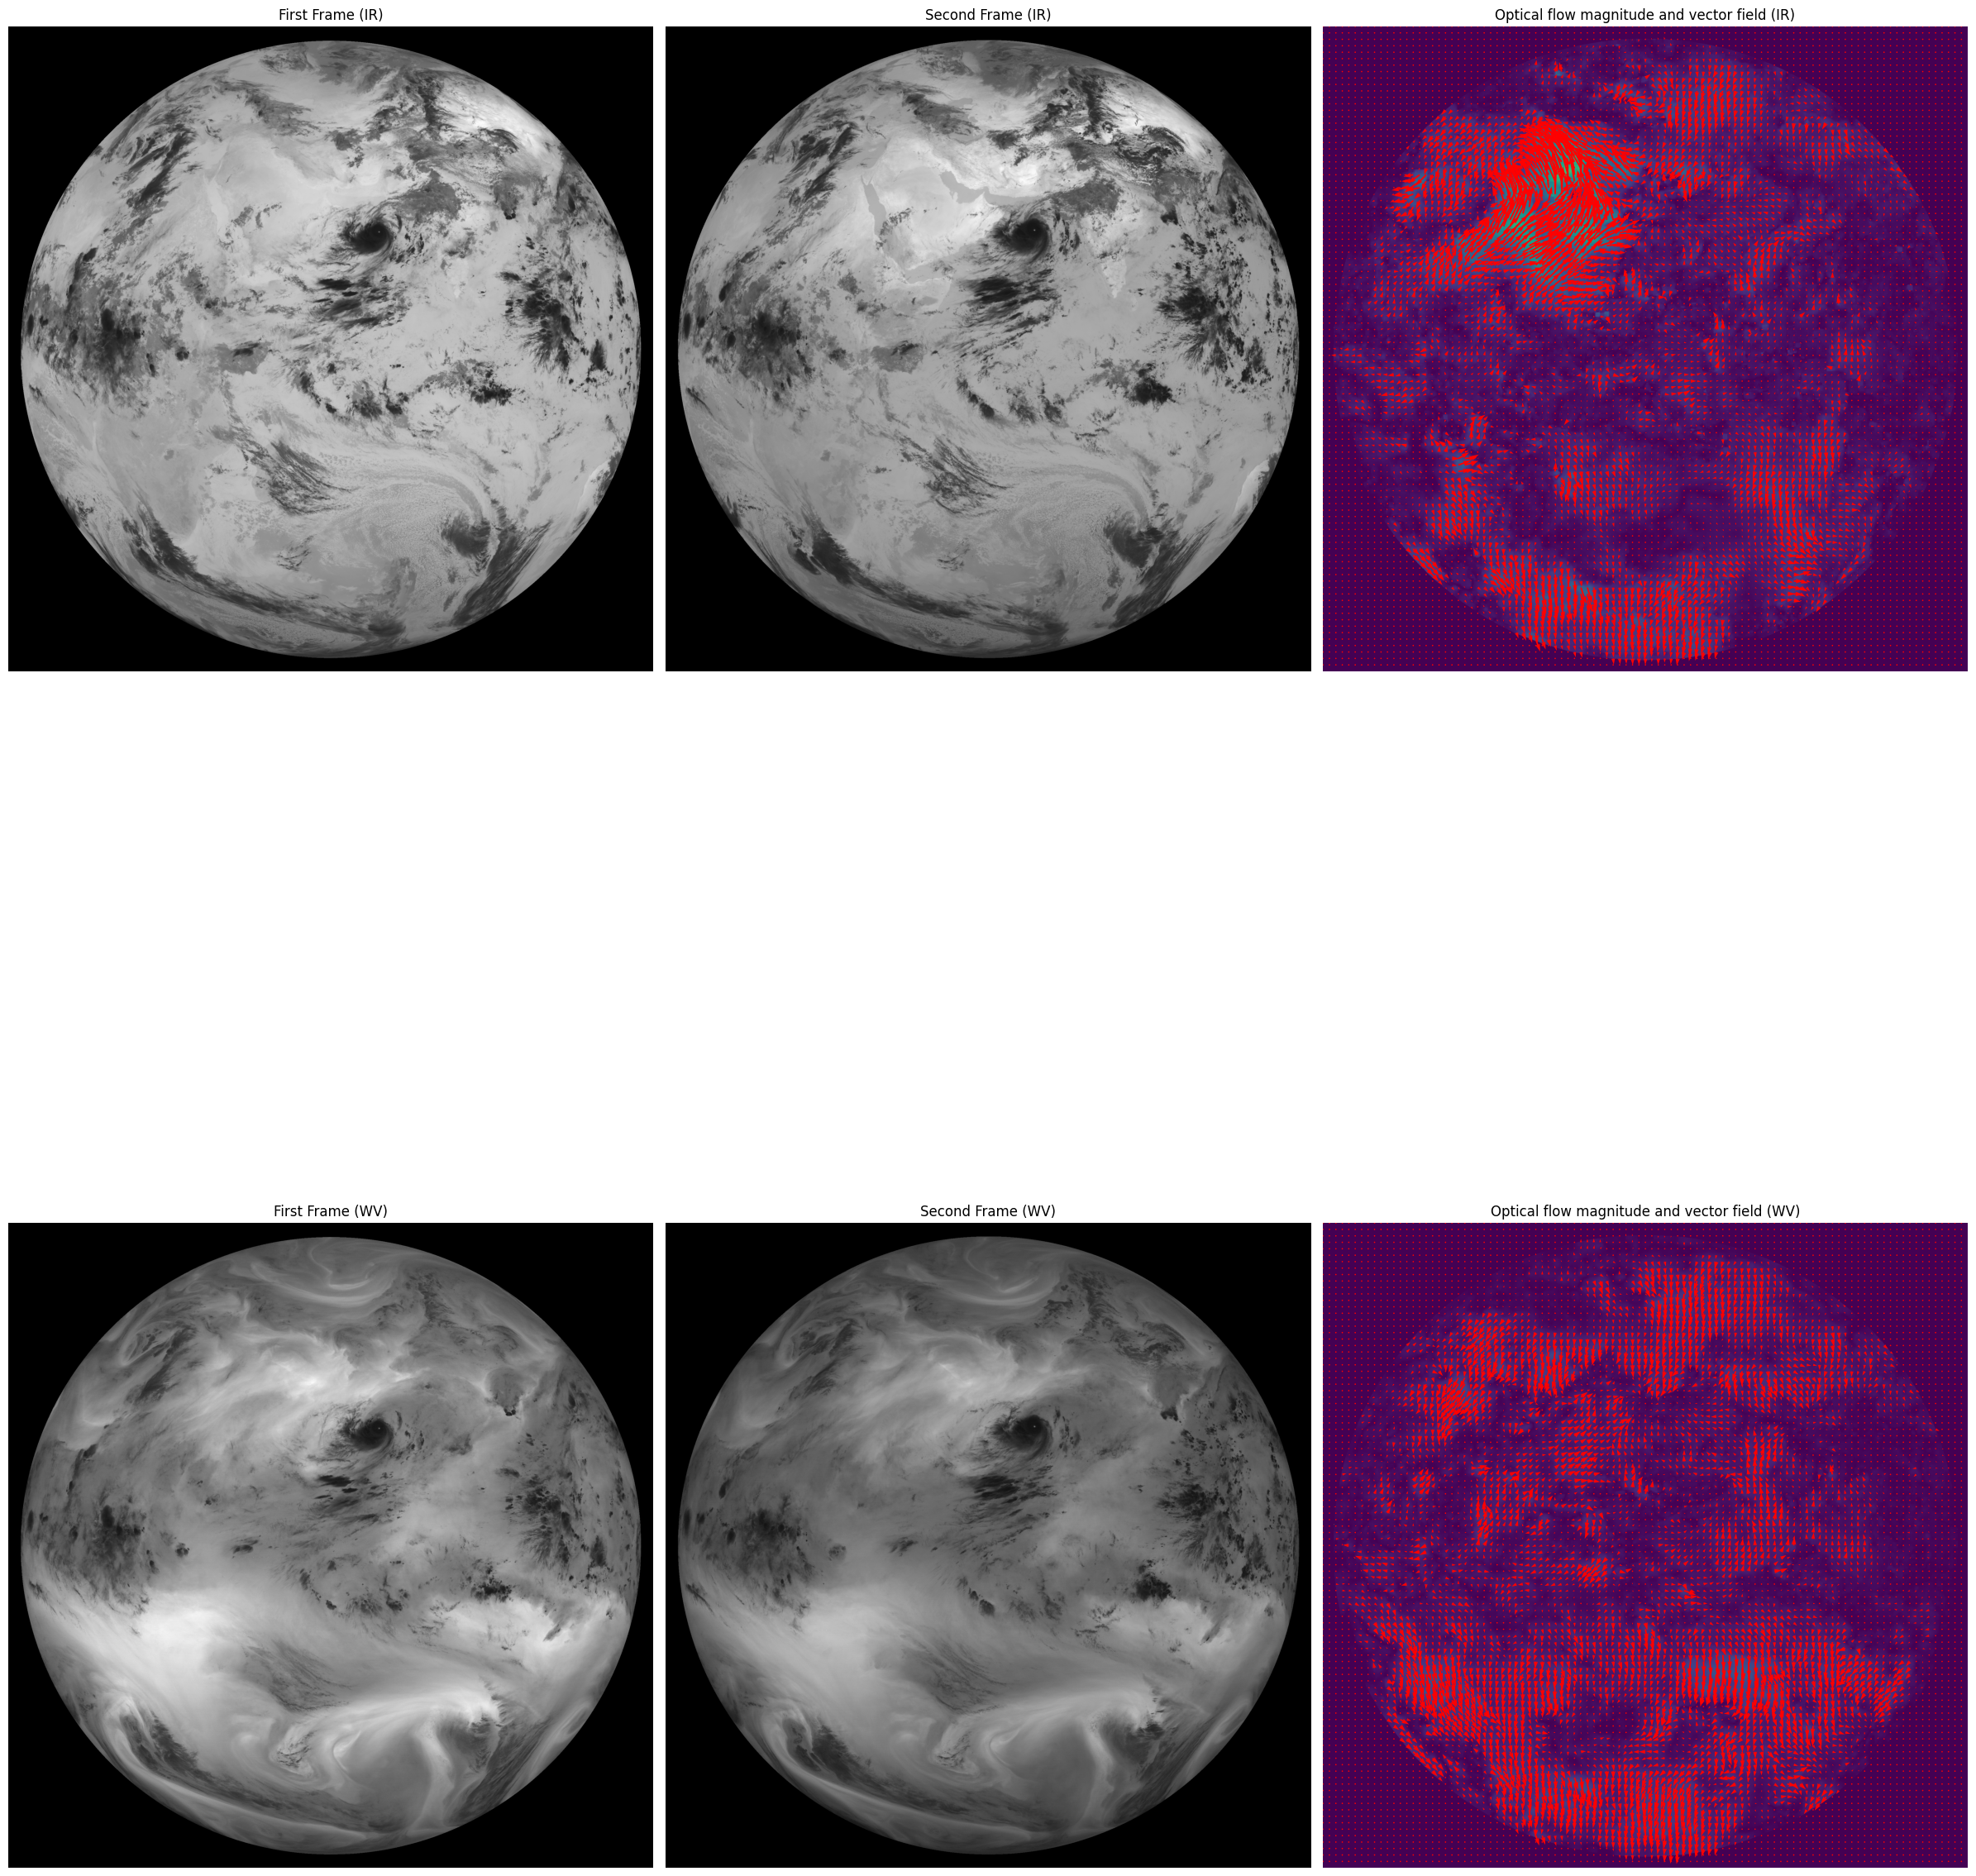

In [75]:
INPUT_FILE = '..\\CycloneTrackForecasting\\ibtracs_ni_dataset.csv'
INPUT_FOLDER = '..\\CycloneTrackForecasting\\reprocessing\\output\\'

def calculate_vectors(img1, img2):
    u, v = optical_flow_ilk(img1, img2, num_warp=1)
    norm = np.sqrt(u**2 + v**2)

    return u, v, norm

def process_image_pair(p1, p2):
    img1 = cv2.imread(f'{INPUT_FOLDER}{p1}.png')
    img2 = cv2.imread(f'{INPUT_FOLDER}{p2}.png')

    ir1 = img1[:, :, 1]
    ir2 = img2[:, :, 1]
    u_ir, v_ir, norm_ir = calculate_vectors(ir1, ir2)

    wv1 = img1[:, :, 0]
    wv2 = img2[:, :, 0]
    u_wv, v_wv, norm_wv = calculate_vectors(wv1, wv2)

    fig, axs = plt.subplots(2, 3, figsize=(24, 36))

    axs[0, 0].imshow(ir1, cmap='gray')
    axs[0, 0].set_title("First Frame (IR)")
    axs[0, 0].set_axis_off()

    axs[0, 1].imshow(ir2, cmap='gray')
    axs[0, 1].set_title("Second Frame (IR)")
    axs[0, 1].set_axis_off()

    nvec = 100  # Number of vectors to be displayed along each image dimension
    nl, nc = img1[:, :, 0].shape
    step = max(nl // nvec, nc // nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u_ir[::step, ::step]
    v_ = v_ir[::step, ::step]

    axs[0, 2].imshow(norm_ir)
    axs[0, 2].quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale_units='xy', lw=3)
    axs[0, 2].set_title("Optical flow magnitude and vector field (IR)")
    axs[0, 2].set_axis_off()

    axs[1, 0].imshow(wv1, cmap='gray')
    axs[1, 0].set_title("First Frame (WV)")
    axs[1, 0].set_axis_off()

    axs[1, 1].imshow(wv2, cmap='gray')
    axs[1, 1].set_title("Second Frame (WV)")
    axs[1, 1].set_axis_off()

    u_ = u_wv[::step, ::step]
    v_ = v_wv[::step, ::step]

    axs[1, 2].imshow(norm_wv)
    axs[1, 2].quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale_units='xy', lw=3)
    axs[1, 2].set_title("Optical flow magnitude and vector field (WV)")
    axs[1, 2].set_axis_off()
    
    fig.tight_layout()

df = pd.read_csv(INPUT_FILE)
blah = pd.to_datetime(df.ISO_TIME, dayfirst=True)
df['timestamp'] = blah
df['filename'] = df['timestamp'].dt.strftime('%Y%m%d%H%M%S')
rows = df.values.tolist()
row = rows[33]

filename = row[6]
timestamp = row[5]
f1 = timestamp - timedelta(hours=6)
f2 = timestamp - timedelta(hours=3)
f1 = f"{f1.year:04}{f1.month:02}{f1.day:02}{f1.hour:02}{f1.minute:02}{f1.second:02}"
f2 = f"{f2.year:04}{f2.month:02}{f2.day:02}{f2.hour:02}{f2.minute:02}{f2.second:02}"

foo = process_image_pair(f1, f2)

## Step 4 : Velocity Bands

First, we start by constructing a lookup table that takes the latitude and longitude from the [IBTrACs dataset](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/) and maps it to its corresponding pixel on each geostationary image.

Then, we create successive 1° bands from the centre of the cyclone, and get the average velocity in that region.

['GONU', '04-06-2007 09:00', 'TS', 19.5, 64.5, Timestamp('2007-06-04 09:00:00'), '20070604090000']
[[ 952 1427]
 [ 916 1316]
 [ 880 1279]
 [ 775 1243]
 [ 674 1277]
 [ 642 1311]
 [ 610 1409]
 [ 644 1510]
 [ 677 1547]
 [ 778 1591]
 [ 882 1566]
 [ 917 1533]]
[<Axes: > <Axes: > <Axes: >]
(2500, 2500)


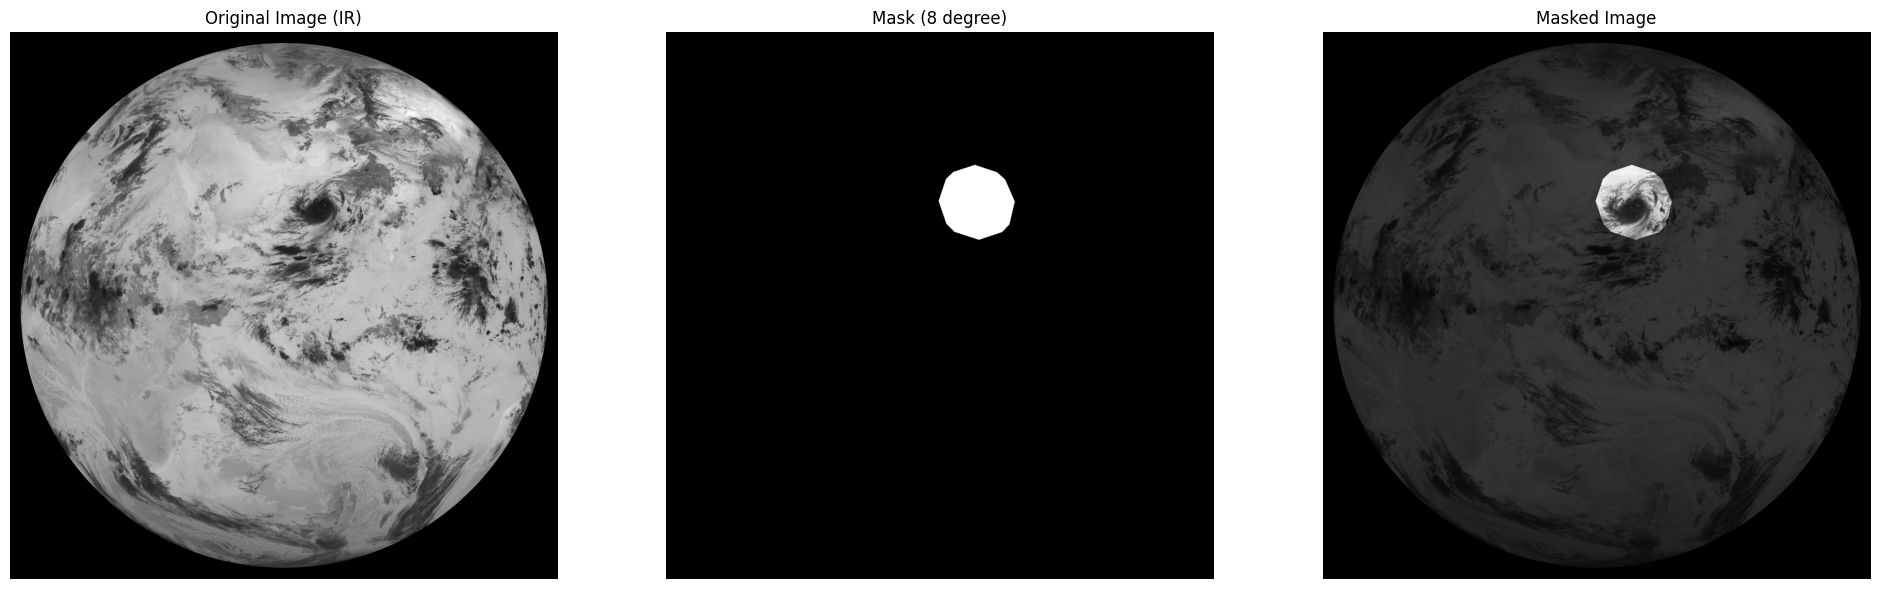

In [63]:
def LUT(file="..\\CycloneTrackForecasting\\latlon_pixel_map.csv"):
    df = pd.read_csv(file)
    foo = df.values.tolist()
    lut = {}

    for lat, lon, x, y in foo:
        lut[lat, lon] = (int(y), int(x))
    
    return lut

COORDINATE_LUT = LUT()

def create_mask(lat, lon, dia_deg):
    # Mask Points
    pts =[[-0.5, 0.0], [-0.4, -0.3], [-0.3, -0.4], [0.0, -0.5], [0.3, -0.4], [0.4, -0.3], [0.5, 0.0], [0.4, 0.3], [0.3, 0.4], [0.0, 0.5], [-0.3, 0.4], [-0.4, 0.3]]
    pts = [[x*dia_deg, y*dia_deg] for x, y in pts]
    pts = [[x+lat, y+lon] for x, y in pts]
    pts = np.array([COORDINATE_LUT[(round(x*10)/10, round(y*10)/10)] for x, y in pts])
    print(pts)
    
    mask = polygon2mask((2500, 2500), pts).astype(int)
    arr = np.where(mask < 1, 0.5, mask)

    return mask+arr

def plot_mask(lat, lon, i, img):
    mask = create_mask(lat, lon, i)

    ir = img[:, :, 1]
    final = mask * ir

    fig, axs = plt.subplots(1, 3, figsize=(24, 72))
    print(axs)
    print(ir.shape)

    axs[0].imshow(ir, cmap='gray')
    axs[0].set_title("Original Image (IR)")
    axs[0].set_axis_off()

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Mask (8 degree)")
    axs[1].set_axis_off()

    axs[2].imshow(final, cmap='gray')
    axs[2].set_title("Masked Image")
    axs[2].set_axis_off()
    
print(row)
img1 = cv2.imread(f'{INPUT_FOLDER}{f1}.png')
img2 = cv2.imread(f'{INPUT_FOLDER}{f2}.png')
lat, lon = row[3], row[4]
plot_mask(lat, lon, 15, img1)

In [65]:
def create_mask(lat, lon, dia_deg):
    # Mask Points
    pts =[[-0.5, 0.0], [-0.4, -0.3], [-0.3, -0.4], [0.0, -0.5], [0.3, -0.4], [0.4, -0.3], [0.5, 0.0], [0.4, 0.3], [0.3, 0.4], [0.0, 0.5], [-0.3, 0.4], [-0.4, 0.3]]
    pts = [[x*dia_deg, y*dia_deg] for x, y in pts]
    pts = [[x+lat, y+lon] for x, y in pts]
    pts = np.array([COORDINATE_LUT[(round(x*10)/10, round(y*10)/10)] for x, y in pts])

    # Create Polygon Mask
    mask = polygon2mask((2500, 2500), pts).astype(int)
    return mask


def calculate_vectors(img1, img2, lat, lon):
    velocity = optical_flow_ilk(img1, img2, num_warp=1)
    
    avg_velocities  = []
    
    # Calculate velocity at 8 bands
    for i in range(8):
        inner_mask = create_mask(lat, lon, i)
        outer_mask = create_mask(lat, lon, i+1)

        # Apply mask
        mask = outer_mask - inner_mask
        
        # Calculate velocity from bands
        vx_band = velocity[0] * mask
        vy_band = velocity[1] * mask

        # Get average velocity in band
        avg_vx = np.sum(vx_band) / np.sum(mask)
        avg_vy = np.sum(vy_band) / np.sum(mask)

        avg_velocities += [avg_vx, avg_vy]
    
    return avg_velocities


def process_image_pair(p1, p2, lat, lon):
    # If image doesn't exist, skip
    try:
        img1 = cv2.imread(f'{INPUT_FOLDER}{p1}.png')
        img2 = cv2.imread(f'{INPUT_FOLDER}{p2}.png')

        # Calculate for IR channel
        ir1 = img1[:, :, 1]
        ir2 = img2[:, :, 1]

    except TypeError:
        return None

    ir = calculate_vectors(ir1, ir2, lat, lon)
    if not ir:
        return None

    # Calculate for WV channel
    wv1 = img1[:, :, 0]
    wv2 = img2[:, :, 0]

    wv = calculate_vectors(wv1, wv2, lat, lon)

    return ir + wv

img1 = cv2.imread(f'{INPUT_FOLDER}{f1}.png')
img2 = cv2.imread(f'{INPUT_FOLDER}{f2}.png')
lat, lon = row[3], row[4]
res = process_image_pair(f1, f2, row[3], row[4])

len(res), res

(32,
 [np.float64(-15.865358662605285),
  np.float64(-10.090948939993977),
  np.float64(-11.812960730791092),
  np.float64(-7.8656285521698495),
  np.float64(-9.693773812565462),
  np.float64(-7.720226531090767),
  np.float64(-9.766519668280768),
  np.float64(-8.0470497432994),
  np.float64(-9.263609985224514),
  np.float64(-7.383049953947353),
  np.float64(-7.916616387933622),
  np.float64(-7.287268754269609),
  np.float64(-6.371178241197846),
  np.float64(-6.4279210953428),
  np.float64(-5.382642959628447),
  np.float64(-5.567742288330881),
  np.float64(-14.493093283176423),
  np.float64(-10.42943895816803),
  np.float64(-11.761791580120722),
  np.float64(-9.356309723655382),
  np.float64(-10.767377589332156),
  np.float64(-8.980101963589942),
  np.float64(-11.599854829489875),
  np.float64(-9.159281860865802),
  np.float64(-11.86547203720743),
  np.float64(-8.344517808975986),
  np.float64(-10.801780644811931),
  np.float64(-7.56923584040355),
  np.float64(-9.073601845749513),
  np.

## Step 5 : Sheer Calculation

Here, sheer is calculated with the formula

$S = \frac{x_{i+1} - x_{i}}{y_{i+1} - y_i}$

This is calculated on the final dataframe directly as follow


In [73]:
columns = ['filename']

for ch in ['ir', 'wv']:
    for i in range(1, 9):
        columns.append(f'vel_{ch}_x_{i}')
        columns.append(f'vel_{ch}_y_{i}')

output = pd.DataFrame([[f1]+res], columns=columns)

# Sheer Calculations
for wavelength in ['ir', 'wv']:
    for i in range(1, 8):
        col1 = f'vel_{wavelength}_x_{i+1}'
        col2 = f'vel_{wavelength}_x_{i}'
        col3 = f'vel_{wavelength}_y_{i+1}'
        col4 = f'vel_{wavelength}_y_{i}'

        diff_col = f'sheer_{wavelength}_{i}'
        output[diff_col] = (output[col1] - output[col2]) / (output[col3] - output[col4])

output.columns

Index(['filename', 'vel_ir_x_1', 'vel_ir_y_1', 'vel_ir_x_2', 'vel_ir_y_2',
       'vel_ir_x_3', 'vel_ir_y_3', 'vel_ir_x_4', 'vel_ir_y_4', 'vel_ir_x_5',
       'vel_ir_y_5', 'vel_ir_x_6', 'vel_ir_y_6', 'vel_ir_x_7', 'vel_ir_y_7',
       'vel_ir_x_8', 'vel_ir_y_8', 'vel_wv_x_1', 'vel_wv_y_1', 'vel_wv_x_2',
       'vel_wv_y_2', 'vel_wv_x_3', 'vel_wv_y_3', 'vel_wv_x_4', 'vel_wv_y_4',
       'vel_wv_x_5', 'vel_wv_y_5', 'vel_wv_x_6', 'vel_wv_y_6', 'vel_wv_x_7',
       'vel_wv_y_7', 'vel_wv_x_8', 'vel_wv_y_8', 'sheer_ir_1', 'sheer_ir_2',
       'sheer_ir_3', 'sheer_ir_4', 'sheer_ir_5', 'sheer_ir_6', 'sheer_ir_7',
       'sheer_wv_1', 'sheer_wv_2', 'sheer_wv_3', 'sheer_wv_4', 'sheer_wv_5',
       'sheer_wv_6', 'sheer_wv_7'],
      dtype='object')

In [74]:
output

filename  vel_ir_x_1  vel_ir_y_1  vel_ir_x_2  vel_ir_y_2  vel_ir_x_3  \
0  20070604030000  -15.865359  -10.090949  -11.812961   -7.865629   -9.693774   

   vel_ir_y_3  vel_ir_x_4  vel_ir_y_4  vel_ir_x_5  ...  sheer_ir_5  \
0   -7.720227    -9.76652    -8.04705    -9.26361  ...   14.063236   

   sheer_ir_6  sheer_ir_7  sheer_wv_1  sheer_wv_2  sheer_wv_3  sheer_wv_4  \
0    1.798385    1.149221    2.545175    2.643258    4.646042   -0.326005   

   sheer_wv_5  sheer_wv_6  sheer_wv_7  
0    1.372006    4.239523     1.01784  

[1 rows x 47 columns]